<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [8]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [9]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  train_ds = ImageFolder(root = "/kaggle/input/faces-dataset-small/", transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
  ]))
  
  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

  return train_dl
    

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [11]:
image_size = 128
batch_size = 32
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_dl = get_dataloader(image_size, batch_size)

In [12]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [13]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

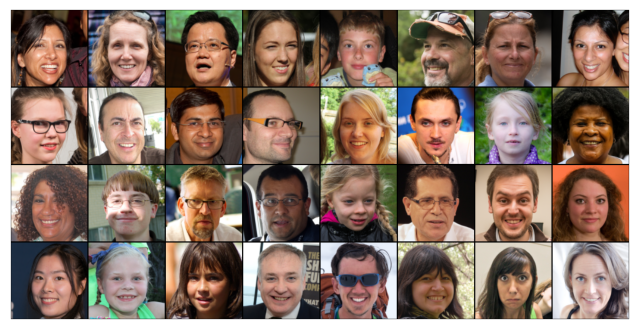

In [14]:
show_batch(train_dl)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [15]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8
    
    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [16]:
latent_size = 256 # choose latent size

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 64 x 64

    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

torch.Size([32, 3, 128, 128])


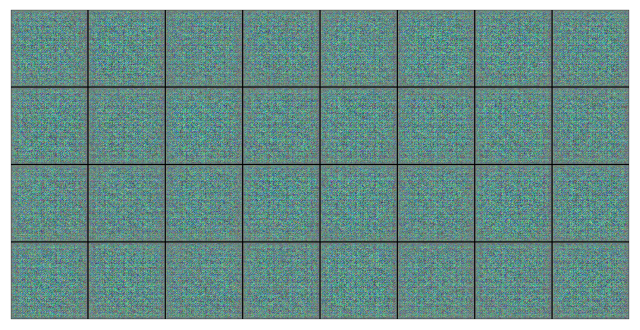

In [19]:
xb = torch.randn(batch_size, latent_size, 1, 1).cpu()
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images.cpu())

In [20]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [21]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [22]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [23]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            
            real_images = real_images.to(device)
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [24]:
lr = 0.0001

model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

epochs = 40

In [68]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 7.7873, loss_d: 0.1633, real_score: 0.9469, fake_score: 0.0561


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 8.5267, loss_d: 0.2070, real_score: 0.9373, fake_score: 0.0623


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 7.9191, loss_d: 0.2421, real_score: 0.9297, fake_score: 0.0691


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 8.1641, loss_d: 0.2754, real_score: 0.9222, fake_score: 0.0754


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 7.7125, loss_d: 0.2212, real_score: 0.9357, fake_score: 0.0662


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 7.6021, loss_d: 0.1874, real_score: 0.9385, fake_score: 0.0579


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 7.9078, loss_d: 0.1708, real_score: 0.9435, fake_score: 0.0554


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 8.0455, loss_d: 0.2631, real_score: 0.9334, fake_score: 0.0664


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 8.7023, loss_d: 0.2596, real_score: 0.9216, fake_score: 0.0741


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 6.8649, loss_d: 0.1510, real_score: 0.9486, fake_score: 0.0534


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 8.2319, loss_d: 0.2451, real_score: 0.9322, fake_score: 0.0616


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 8.1556, loss_d: 0.1667, real_score: 0.9465, fake_score: 0.0538


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 7.1575, loss_d: 0.1359, real_score: 0.9502, fake_score: 0.0467


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 7.5934, loss_d: 0.2859, real_score: 0.9268, fake_score: 0.0748


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 8.1572, loss_d: 0.2299, real_score: 0.9333, fake_score: 0.0697


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 6.8072, loss_d: 0.1189, real_score: 0.9530, fake_score: 0.0436


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 8.6673, loss_d: 0.1118, real_score: 0.9619, fake_score: 0.0424


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 8.2599, loss_d: 0.1924, real_score: 0.9377, fake_score: 0.0518


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 8.2020, loss_d: 0.2914, real_score: 0.9429, fake_score: 0.0634


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 7.0679, loss_d: 0.1462, real_score: 0.9489, fake_score: 0.0499


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 7.9088, loss_d: 0.1427, real_score: 0.9522, fake_score: 0.0476


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 8.2082, loss_d: 0.2444, real_score: 0.9390, fake_score: 0.0561


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 7.4248, loss_d: 0.1693, real_score: 0.9493, fake_score: 0.0515


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 8.3010, loss_d: 0.2201, real_score: 0.9370, fake_score: 0.0629


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 7.0432, loss_d: 0.0995, real_score: 0.9600, fake_score: 0.0396


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 7.6795, loss_d: 0.1142, real_score: 0.9570, fake_score: 0.0421


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 7.7335, loss_d: 0.1001, real_score: 0.9608, fake_score: 0.0356


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 7.7917, loss_d: 0.2581, real_score: 0.9364, fake_score: 0.0662


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 8.3981, loss_d: 0.1434, real_score: 0.9552, fake_score: 0.0440


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 9.8777, loss_d: 0.3247, real_score: 0.9343, fake_score: 0.0650


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 7.0041, loss_d: 0.1078, real_score: 0.9578, fake_score: 0.0433


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 7.1562, loss_d: 0.2090, real_score: 0.9390, fake_score: 0.0582


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 6.7739, loss_d: 0.0806, real_score: 0.9665, fake_score: 0.0330


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 8.2092, loss_d: 0.1404, real_score: 0.9516, fake_score: 0.0461


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 8.8565, loss_d: 0.2250, real_score: 0.9394, fake_score: 0.0617


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 7.5640, loss_d: 0.1284, real_score: 0.9544, fake_score: 0.0444


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 7.8349, loss_d: 0.0834, real_score: 0.9654, fake_score: 0.0305


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 8.8799, loss_d: 0.3433, real_score: 0.9330, fake_score: 0.0703


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 7.8334, loss_d: 0.1166, real_score: 0.9574, fake_score: 0.0411


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 7.0786, loss_d: 0.0954, real_score: 0.9631, fake_score: 0.0359
Saving generated-images-0040.png


Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [75]:
losses_g, losses_d, real_scores, fake_scores = history

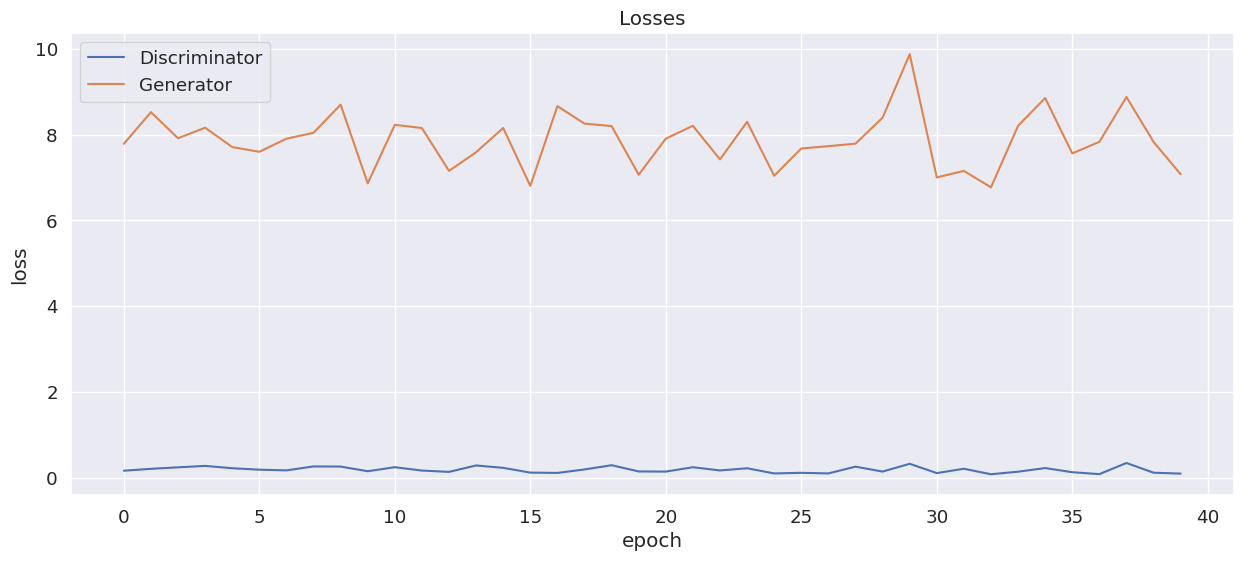

In [76]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

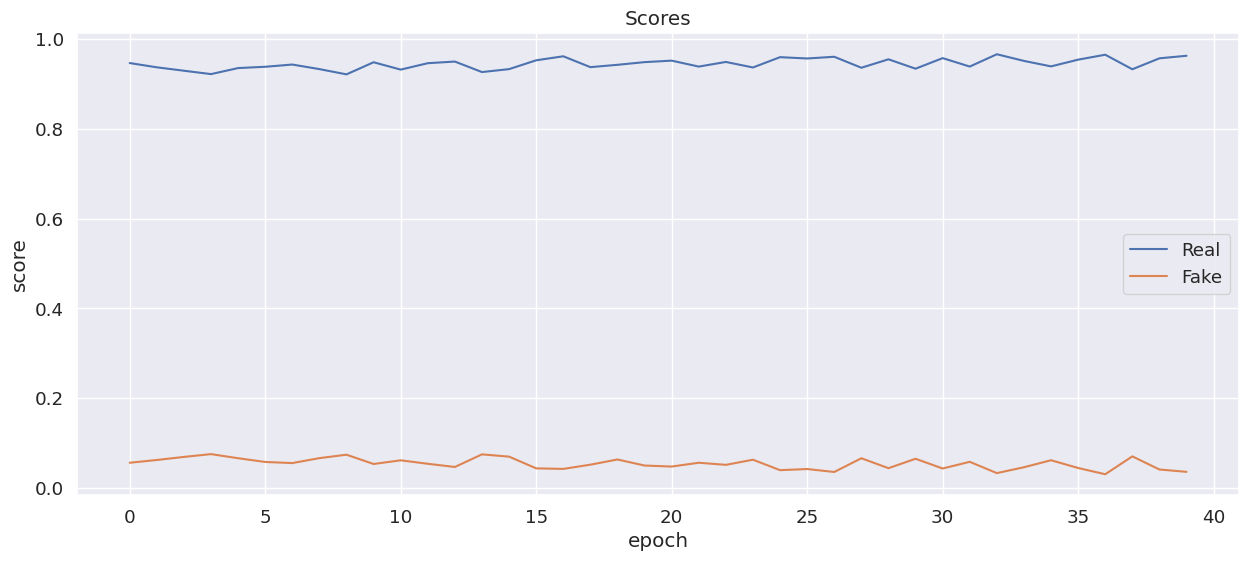

In [77]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [25]:
discriminator = torch.load("/kaggle/input/hw-gan-weights/discriminator.pth")
generator = torch.load("/kaggle/input/hw-gan-weights/generator.pth")

model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

In [26]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [27]:
def show_generated_images(generated):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(generated.detach()[:64]), nrow=8).permute(1, 2, 0))

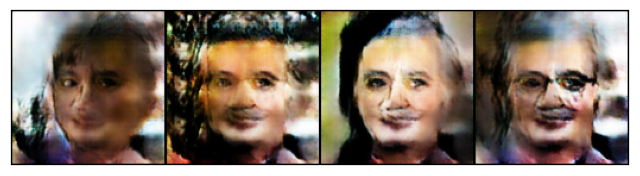

In [28]:
show_generated_images(fake_images.cpu())

Как вам качество получившихся изображений?

В целом что-то похожее есть, но слишком много артефактов.

In [82]:
torch.save(discriminator, "/kaggle/working/discriminator.pth")
torch.save(generator, "/kaggle/working/generator.pth")

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [113]:
import numpy as np

In [92]:
real_img = ImageFolder(root = "/kaggle/input/faces-dataset-small/", transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
  ]))

real_img

Dataset ImageFolder
    Number of datapoints: 3143
    Root location: /kaggle/input/faces-dataset-small/
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(128, 128))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

In [96]:
model["generator"].eval()
n_images = 320

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

fake_images.shape

torch.Size([320, 3, 128, 128])

In [99]:
fake_targets = torch.ones(n_images, device=device)

In [106]:
from torch.utils.data import TensorDataset

f_ds = TensorDataset(fake_images, fake_targets)

fake_dataloader = DataLoader(dataset=f_ds)

In [118]:
X = np.array([])
Y = np.array([])

for x, y in fake_dataloader:
    x = x.cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    
    X = np.append(X, x)
    Y = np.append(Y, y)

In [119]:
c = 0
for x, y in train_dl:
    x = x.cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    
    X = np.append(X, x)
    Y = np.append(Y, y)
    
    c+=1
    if (c==10):
        break

In [124]:
X = np.reshape(X, (640, -1))

In [134]:
X.shape

(640, 49152)

In [135]:
Y.shape

(640,)

In [155]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

loo = LeaveOneOut()

acc = 0

for train_index, test_index in loo.split(X):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    neigh = KNeighborsClassifier(n_neighbors=3)

    neigh.fit(X_train, y_train)
    
    pred = neigh.predict(X_test)
    
    if (pred == y_test):
        acc+=1

In [156]:
print("ACCURACY: ", acc/640)

ACCURACY:  0.9515625


Как видим, несмотря на то, что картинки получаются более менее похожие на лица, KNN все равно их различает :(

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [157]:
from sklearn.manifold import TSNE

latent_faces = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(X)

latent_faces.shape

(640, 2)

In [158]:
x, y = np.hsplit(latent_faces, 2)

x = x.flatten()
y = y.flatten()

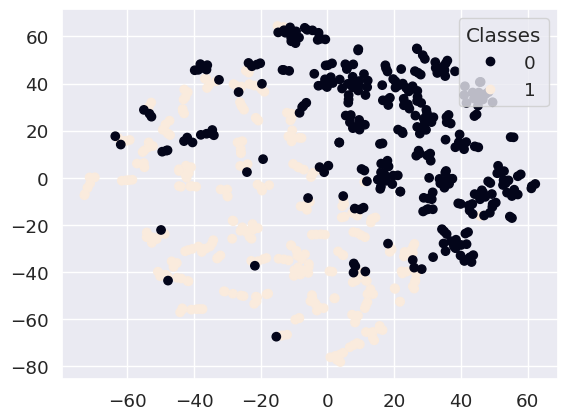

In [159]:
scatter = plt.scatter(x=x, y=y, c = Y)

legend = plt.legend(*scatter.legend_elements(), loc="upper right", title="Classes")

plt.show()

Прокомментируйте получившийся результат:

Как видим фейковые лица отделимы от настоящих, но некоторые пересечения есть